# Bank telemarketing

Los datos están relacionados con campañas de marketing directo de una institución bancaria portuguesa. Las campañas de marketing se basaron en llamadas telefónicas. A menudo, se requería más de un contacto con el mismo cliente, para poder acceder si el producto (depósito a plazo bancario) estaría ('sí') o no ('no') suscrito.

Los datos han sido obtenido del sitio web:

https://archive.ics.uci.edu/ml/datasets/bank+marketing

## Implementación 

### Instalación y carga de librerías 

In [1]:
#!pip install imblearn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import pickle
import warnings
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [3]:
warnings.filterwarnings("ignore") # desactivar warnings

Definimos ruta del dataset input y se procede a cargar el archivo

In [4]:
ruta_input="C:/Users/Omar/Desktop/Omar/Temas data science/Bases/Bank telemarketing"

In [5]:
base_banco=pd.read_csv(os.path.join(ruta_input,"base_para_modelar.csv"))

Revisemos el tipo de variables

In [6]:
base_banco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40689 entries, 0 to 40688
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  40689 non-null  int64 
 1   age         40689 non-null  int64 
 2   job         40689 non-null  object
 3   marital     40689 non-null  object
 4   education   40689 non-null  object
 5   default     40689 non-null  object
 6   balance     40689 non-null  int64 
 7   housing     40689 non-null  object
 8   loan        40689 non-null  object
 9   contact     40689 non-null  object
 10  day         40689 non-null  int64 
 11  month       40689 non-null  object
 12  duration    40689 non-null  int64 
 13  campaign    40689 non-null  int64 
 14  pdays       40689 non-null  int64 
 15  previous    40689 non-null  int64 
 16  poutcome    40689 non-null  object
 17  y           40689 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 5.6+ MB


In [7]:
base_banco.head()

,Unnamed: 0,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,17337,34,technician,married,secondary,no,0,yes,no,telephone,28,jul,1025,2,-1,0,unknown,0
1,43321,31,student,single,unknown,no,7826,no,no,telephone,17,mar,133,7,-1,0,unknown,0
2,19379,36,management,single,tertiary,no,900,no,no,cellular,6,aug,499,4,-1,0,unknown,0
3,12230,40,unemployed,married,tertiary,no,1558,yes,no,unknown,20,jun,44,15,-1,0,unknown,0
4,9061,45,blue-collar,married,unknown,no,419,no,no,unknown,5,jun,420,1,-1,0,unknown,0


In [8]:
base_banco.y.value_counts()

0    35929
1     4760
Name: y, dtype: int64

In [9]:
print('porc. no')
print((base_banco['y'][base_banco.y==0].count())/(base_banco.shape[0]))
print('porc. si')
print((base_banco['y'][base_banco.y==1].count())/(base_banco.shape[0]))

porc. no
0.8830150654968173
porc. si
0.11698493450318267


## Empecemos con el modelado

La primera etapa en un proyecto de data sciene es **la limpieza de los datos**.

Convertimos las variables cualitativas en cuantitativas; para este caso , como **housting, loan y default** tienen como elementos **yes** y **no**, se puede representar como **1 y 0**

Para la variable **month** se puede hacer de dos formas:
1. Como cada mes representa un orden, se le puede asignar un número a cada mes.
2. Se puede generar para cada variable una variable nueva (dummies)

In [10]:
data_banco=base_banco.copy()

In [11]:
# housing, loan
data_banco.loc[data_banco['housing']=='yes',['housing']]=1
data_banco.loc[data_banco['housing']=='no',['housing']]=0
data_banco.loc[data_banco['loan']=='yes',['loan']]=1
data_banco.loc[data_banco['loan']=='no',['loan']]=0
data_banco.loc[data_banco['default']=='yes',['default']]=1
data_banco.loc[data_banco['default']=='no',['default']]=0
###
data_banco.loc[data_banco['month']=='jan',['month']]=1
data_banco.loc[data_banco['month']=='feb',['month']]=2
data_banco.loc[data_banco['month']=='mar',['month']]=3
data_banco.loc[data_banco['month']=='apr',['month']]=4
data_banco.loc[data_banco['month']=='may',['month']]=5
data_banco.loc[data_banco['month']=='jun',['month']]=6
data_banco.loc[data_banco['month']=='jul',['month']]=7
data_banco.loc[data_banco['month']=='aug',['month']]=8
data_banco.loc[data_banco['month']=='sep',['month']]=9
data_banco.loc[data_banco['month']=='oct',['month']]=10
data_banco.loc[data_banco['month']=='nov',['month']]=11
data_banco.loc[data_banco['month']=='dec',['month']]=12

In [12]:
data_banco_bkp=data_banco.copy()

In [13]:
data_banco.head()

,Unnamed: 0,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,17337,34,technician,married,secondary,0,0,1,0,telephone,28,7,1025,2,-1,0,unknown,0
1,43321,31,student,single,unknown,0,7826,0,0,telephone,17,3,133,7,-1,0,unknown,0
2,19379,36,management,single,tertiary,0,900,0,0,cellular,6,8,499,4,-1,0,unknown,0
3,12230,40,unemployed,married,tertiary,0,1558,1,0,unknown,20,6,44,15,-1,0,unknown,0
4,9061,45,blue-collar,married,unknown,0,419,0,0,unknown,5,6,420,1,-1,0,unknown,0


Generando varibles dummies para las otras variables cualitativas

In [14]:
base_dummies=pd.get_dummies(data_banco[['job','marital','education','contact','poutcome']])

In [15]:
data_banco=pd.concat([data_banco,base_dummies],axis=1)

In [16]:
data_banco.shape

(40689, 44)

In [17]:
data_banco.columns

Index(['Unnamed: 0', 'age', 'job', 'marital', 'education', 'default',
       'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome', 'y', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [18]:
data_banco.head()

,Unnamed: 0,age,job,marital,education,default,balance,housing,loan,contact,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,17337,34,technician,married,secondary,0,0,1,0,telephone,...,1,0,0,0,1,0,0,0,0,1
1,43321,31,student,single,unknown,0,7826,0,0,telephone,...,0,0,1,0,1,0,0,0,0,1
2,19379,36,management,single,tertiary,0,900,0,0,cellular,...,0,1,0,1,0,0,0,0,0,1
3,12230,40,unemployed,married,tertiary,0,1558,1,0,unknown,...,0,1,0,0,0,1,0,0,0,1
4,9061,45,blue-collar,married,unknown,0,419,0,0,unknown,...,0,0,1,0,0,1,0,0,0,1


Quitando las variables cualitativas (probar de otra forma)

In [19]:
X=['age', 'default', 'balance', 'housing',
       'loan', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown']
Y=['y']

Separando los dataframe:
1. Base_X: Variables independientes.
2. Base_y: Variable dependiente (target).

In [20]:
base_X=data_banco[X]
base_y=data_banco[Y]

Cambiamos tipo de datos a algunas variables para que no tengamos problemas al ejecutar el modelo

In [21]:
base_X['month'].apply(int)
base_X['default']=base_X['default'].apply(int)
base_X['housing']=base_X['housing'].apply(int)
base_X['loan']=base_X['loan'].apply(int)
base_y['y']=base_y['y'].apply(int)

## IMPORTANTE!!!

Para el modelo de regresión logística es recomendable estandarizar los datos, para evitar el overfitting.

Vamos aplicar **apply** para aplicar la normalización, mas adelante veremos que hay librerías que se encargar de la estandarización

In [22]:
base_X_scal=base_X.apply(lambda x: (x-x.mean())/x.std(), axis=0)

In [23]:
base_X_scal.head()

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,-0.651253,-0.135725,-0.447938,0.893971,-0.437458,1.463471,0.354764,2.981529,-0.246447,-0.411751,...,0.972759,-0.644368,-0.207136,-1.356896,3.802498,-0.634869,-0.349533,-0.205063,-0.186591,0.473072
1,-0.933895,-0.135725,2.110603,-1.118577,-0.437458,0.142554,-1.30782,-0.484941,1.361068,-0.411751,...,-1.027979,-0.644368,4.827616,-1.356896,3.802498,-0.634869,-0.349533,-0.205063,-0.186591,0.473072
2,-0.462824,-0.135725,-0.153703,-1.118577,-0.437458,-1.178363,0.77041,0.937400,0.396559,-0.411751,...,-1.027979,1.551870,-0.207136,0.736958,-0.262979,-0.634869,-0.349533,-0.205063,-0.186591,0.473072
3,-0.085967,-0.135725,0.061416,0.893971,-0.437458,0.502804,-0.0608826,-0.830810,3.933092,-0.411751,...,-1.027979,1.551870,-0.207136,-1.356896,-0.262979,1.575089,-0.349533,-0.205063,-0.186591,0.473072
4,0.385105,-0.135725,-0.310955,-1.118577,-0.437458,-1.298446,-0.0608826,0.630392,-0.567950,-0.411751,...,-1.027979,-0.644368,4.827616,-1.356896,-0.262979,1.575089,-0.349533,-0.205063,-0.186591,0.473072


Podemos realizar un análisis de correlación de pearson para **"quitar"** algunas variables, no importa si se hace antes o después de la estandarización, ya que no se ve afectada por la escala

In [24]:
correlacion =base_X_scal.corr()
correlacion.to_csv(os.path.join(ruta_input,'correlacion.csv'))

**Balancear para elegir variables input al modelo**

Para ello usamos el método de smote, que en general va a generar datos de forma artificial de la característica "desbalanceada".

Considerar que el balanceado **solo** se realizará al dataset de entrenamiento.

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

In [25]:
X_traintest, X_val, y_traintest, y_val = train_test_split(base_X_scal, base_y, test_size=0.2, random_state=99)
columns = X_traintest.columns

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_traintest, y_traintest, test_size=0.25, random_state=99)

In [27]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

24413
8138
8138


In [28]:
bal = SMOTE(random_state=0)
bal_data_X,bal_data_y= bal.fit_resample(X_train, y_train)
bal_data_X = pd.DataFrame(data=bal_data_X,columns=columns )
bal_data_y= pd.DataFrame(data=bal_data_y,columns=['y'])
# we can Check the numbers of our data
print("Tamaño de bal_data_x: ",len(bal_data_X))
print("cantidad de registros 0:",len(bal_data_y[bal_data_y['y']==0]))
print("cantidad de registros 1:",len(bal_data_y[bal_data_y['y']==1]))

Tamaño de bal_data_x:  43186
cantidad de registros 0: 21593
cantidad de registros 1: 21593


Así como se puede usar la correlación para "elegir" las variables input del modelo, se puede aplicar el RFE para que mediante iteraciones vaya "eliminando variables" que aporten menos al modelo.

Para nuestro caso, elegiré que el modelo sea de 10 variables.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

Aplicaremos la regresión logística al conjunto de entrenamiento.

In [29]:
modelo_1 = LogisticRegression()

rfe = RFE(modelo_1, n_features_to_select=10)
rfe = rfe.fit(bal_data_X, bal_data_y.values.ravel())

Como resultado el RFE me da la ponderación de importancia de las variables

In [30]:
print(rfe.support_)
print(rfe.ranking_)

[False False False  True  True False False  True  True False False  True
 False False False False False False False  True False False False False
 False False False False  True False False False  True False False  True
  True]
[17 14 13  1  1  8  6  1  1 10 15  1 16 28  9 26  2 11 23  1 19 25 21 24
 18  7  3 20  1 27  4  5  1 22 12  1  1]


In [31]:
bal_data_X.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'month',
       'duration', 'campaign', 'pdays', 'previous', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'],
      dtype='object')

**Con ello, ya obtengo mi dataset final**

In [32]:
X=bal_data_X.iloc[:,[3,4,7,8,11,19,28,32,35,36]]
y=bal_data_y['y']

### Implementación del modelo 

Una buena práctica es revisar el p-valor de las variables en el modelo. Para ello, usamos la regresión logística que está incluida en la librería **stastmodel**

Usamos el modelo de statsmodel para ver el p-valor de las variables

Primero, agregamos la columna de uno al dataset de train

In [33]:
X_stast=sm.add_constant(X)

In [34]:
modelo_logistico=sm.Logit(y,X_stast)
result_modelo_logistico=modelo_logistico.fit()
result_modelo_logistico.summary2()
#print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.409847
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
===================================================================
Model:                Logit            Pseudo R-squared: 0.409     
Dependent Variable:   y                AIC:              35421.2678
Date:                 2021-08-11 15:17 BIC:              35516.6737
No. Observations:     43186            Log-Likelihood:   -17700.   
Df Model:             10               LL-Null:          -29934.   
Df Residuals:         43175            LLR p-value:      0.0000    
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       7.0000                                       
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
const              -1.1105   0.0177 -62.6441 0.0000 -1.1452 -1.0757
housing            -0.5598   0.0148 -37.9285 0.0000 -0.5887 -0.5309
loan               -0.3911   0.0168 -23.3350 0.0000 -0.4239 -0.3582
duration            1.6137   0.0181  88.9690 0.0000  1.5781  1.6492
campaign           -0.5480   0.0238 -22.9850 0.0000 -0.5948 -0.5013
job_admin.          0.1631   0.0132  12.3269 0.0000  0.1371  0.1890
job_student         0.1577   0.0106  14.8293 0.0000  0.1369  0.1786
education_tertiary  0.2300   0.0131  17.6122 0.0000  0.2044  0.2556
contact_unknown    -0.7037   0.0195 -36.0854 0.0000 -0.7419 -0.6655
poutcome_success    0.4062   0.0128  31.8458 0.0000  0.3812  0.4312
poutcome_unknown   -0.1903   0.0135 -14.0530 0.0000 -0.2169 -0.1638
===================================================================

"""

Para nuestro caso, el p-valor de ninguna variable supera el 0.05

**Implementamos el modelo con sklearn**

Dividimos el dataset en dos conjunto: **entrenamiento y validación**

In [35]:
regresion_logistica_f = LogisticRegression()
regresion_logistica_f.fit(X, y)

LogisticRegression()

Una vez entrenado el modelo y guardado en el objeto **regresion_logistica_f**, predecimos usando como base el dataframe de test.

In [36]:
X_test=X_test.iloc[:,[3,4,7,8,11,19,28,32,35,36]]

In [37]:
prediccion = regresion_logistica_f.predict(X_test)
print('Precisión (accuracy) del modelo: ',regresion_logistica_f.score(X_test, y_test))

Precisión (accuracy) del modelo:  0.8246497911034653


### Métricas de evaluación del modelo 

Para evaluar el rendimiento del modelo, usaremos las métricas que obtenemos gracias a la matriz de confusión.

https://interactivechaos.com/es/manual/tutorial-de-machine-learning/disposicion-de-la-matriz-de-confusion

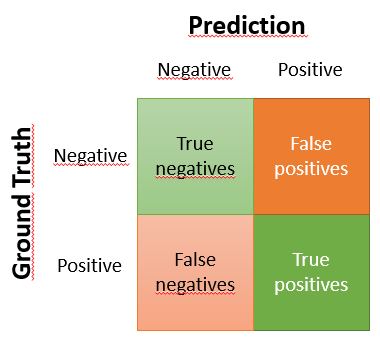

Matriz de confusión (generarla con seaborn para que visualmente se vea mejor)

In [38]:
labels = np.array([0, 1])
confusion_matrix = confusion_matrix(y_test, prediccion,labels = labels)
pd.DataFrame(confusion_matrix, index = labels, columns = labels)

,0,1
0,5937,1224
1,203,774


Métricas del train

In [39]:
from sklearn.metrics import confusion_matrix
prediccion_0 = regresion_logistica_f.predict(X)
confusion_matrix_0 = confusion_matrix(y, prediccion_0)

#Accuracy: (VP+VN)/(VP+FP+FN+VN)
acc_0=(confusion_matrix_0[0][0]+confusion_matrix_0[1][1])/(confusion_matrix_0[0][0]+confusion_matrix_0[0][1]+confusion_matrix_0[1][0]+confusion_matrix_0[1][1])
#precision: VP/(VP+FP)
prec_0=(confusion_matrix_0[1][1])/(confusion_matrix_0[1][1]+confusion_matrix_0[0][1])
#Sensibilidad: VP/(VP+FN)
sens_0=(confusion_matrix_0[1][1])/(confusion_matrix_0[1][1]+confusion_matrix_0[1][0])
#Especificidad:VN/(VN+FP)
esp_0=(confusion_matrix_0[1][1])/(confusion_matrix_0[0][0]+confusion_matrix_0[0][1])
#F1 - score
#2 * (Recall * Precision) / (Recall + Precision)
f1_score_0=2*(sens_0*prec_0)/(sens_0+prec_0)

curva_roc_0 = roc_auc_score(y, regresion_logistica_f.predict(X))

Una vez obtenida la matriz de confusión, se pueden generar las métricas de evaluación del modelo

In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, prediccion,labels = labels)
#Accuracy: (VP+VN)/(VP+FP+FN+VN)
acc=(confusion_matrix[0][0]+confusion_matrix[1][1])/(confusion_matrix[0][0]+confusion_matrix[0][1]+confusion_matrix[1][0]+confusion_matrix[1][1])
print("Accuracy:",acc)
print("\n")
#precision: VP/(VP+FP)
prec=(confusion_matrix[1][1])/(confusion_matrix[1][1]+confusion_matrix[0][1])
print("Precisión:",prec)
print("\n")
#Sensibilidad: VP/(VP+FN)
sens=(confusion_matrix[1][1])/(confusion_matrix[1][1]+confusion_matrix[1][0])
print("Sensibilidad o recall:", sens)
print("\n")
#Especificidad:VN/(VN+FP)
esp=(confusion_matrix[0][0])/(confusion_matrix[0][0]+confusion_matrix[0][1])
print("Especificidad:",esp)
#F1 - score
#2 * (Recall * Precision) / (Recall + Precision)
f1_score=2*(sens*prec)/(sens+prec)
print("\n")
print("F1 score:",f1_score)
print("\n")

Accuracy: 0.8246497911034653


Precisión: 0.38738738738738737


Sensibilidad o recall: 0.7922210849539406


Especificidad: 0.8290741516547968


F1 score: 0.5203361344537815




También se pueden ver las métricas haciendo uso de las librerías que nos da python:

In [41]:
print(classification_report(y_test, prediccion))

              precision    recall  f1-score   support

           0       0.97      0.83      0.89      7161
           1       0.39      0.79      0.52       977

    accuracy                           0.82      8138
   macro avg       0.68      0.81      0.71      8138
weighted avg       0.90      0.82      0.85      8138



Veamos la curva ROC, que no es más que una representación gráfica de la sensibilidad frente a la especificidad para un sistema clasificador binario según se varía el umbral de discriminación. (wikipedia)

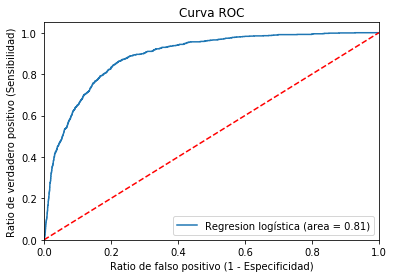

In [42]:
curva_roc = roc_auc_score(y_test, regresion_logistica_f.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, regresion_logistica_f.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Regresion logística (area = %0.2f)' % curva_roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio de falso positivo (1 - Especificidad)')
plt.ylabel('Ratio de verdadero positivo (Sensibilidad)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.savefig('Curva_roc')
plt.show()

Con la curva ROC se puede calcular el índice del gini

In [43]:
print("El valor del gini es: ",2*curva_roc-1)

El valor del gini es:  0.6212952366087374


https://cybertesis.unmsm.edu.pe/bitstream/handle/20.500.12672/7122/Lizares_cm.pdf?sequence=1&isAllowed=y

**Validando con el test del smote**, lo cual me da un conjunto de validación adicional

In [44]:
X_val=X_val.iloc[:,[3,4,7,8,11,19,28,32,35,36]]

In [45]:
prediccion_2 = regresion_logistica_f.predict(X_val)
acc_2=regresion_logistica_f.score(X_val, y_val)
print('Precisión (accuracy) del modelo: ',acc_2)

Precisión (accuracy) del modelo:  0.824404030474318


In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix_2 = confusion_matrix(y_val, prediccion_2)

#Accuracy: (VP+VN)/(VP+FP+FN+VN)
acc_2=(confusion_matrix_2[0][0]+confusion_matrix_2[1][1])/(confusion_matrix_2[0][0]+confusion_matrix_2[0][1]+confusion_matrix_2[1][0]+confusion_matrix_2[1][1])
#precision: VP/(VP+FP)
prec_2=(confusion_matrix_2[1][1])/(confusion_matrix_2[1][1]+confusion_matrix_2[0][1])
#Sensibilidad: VP/(VP+FN)
sens_2=(confusion_matrix_2[1][1])/(confusion_matrix_2[1][1]+confusion_matrix_2[1][0])
#Especificidad:VN/(VN+FP)
esp_2=(confusion_matrix_2[1][1])/(confusion_matrix_2[0][0]+confusion_matrix_2[0][1])
#F1 - score
#2 * (Recall * Precision) / (Recall + Precision)
f1_score_2=2*(sens_2*prec_2)/(sens_2+prec_2)

In [47]:
curva_roc_2 = roc_auc_score(y_val, regresion_logistica_f.predict(X_val))
print("El valor del gini es: ",2*curva_roc_2-1)

El valor del gini es:  0.6093388474605703


Procedemos a guardar el objeto del modelo

In [48]:
filename = 'regresion logistica_10_var.sav'
pickle.dump(regresion_logistica_f, open(os.path.join(ruta_input,filename), 'wb'))

.

Lo siguiente se recomienda desarrollarlo en un notebook diferente

## Validando con data examen

Esta validación nos ayudará para validar que tan bueno está el modelo, y saber si hubo overfitting

In [49]:
data_banco_modelo=pd.read_csv(os.path.join(ruta_input,"base_validacion_curso.csv"))
data_banco_modelo.head()

,Unnamed: 0,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,21039,52,blue-collar,married,unknown,no,51,no,no,cellular,14,aug,935,2,-1,0,unknown,0
1,28258,53,management,married,tertiary,no,232,yes,no,telephone,29,jan,32,1,-1,0,unknown,0
2,25319,50,unemployed,married,secondary,no,525,yes,no,telephone,18,nov,177,2,-1,0,unknown,0
3,15580,32,technician,single,secondary,no,648,no,yes,cellular,21,jul,166,1,-1,0,unknown,0
4,9745,58,housemaid,married,primary,no,2348,no,no,unknown,9,jun,226,1,-1,0,unknown,0


Como vemos, la data esta "cruda", asi que debemos hacerle el mismo tratamiento usado para el dataset anterior

In [50]:
# housing, loan
data_banco_modelo.loc[data_banco_modelo['housing']=='yes',['housing']]=1
data_banco_modelo.loc[data_banco_modelo['housing']=='no',['housing']]=0
data_banco_modelo.loc[data_banco_modelo['loan']=='yes',['loan']]=1
data_banco_modelo.loc[data_banco_modelo['loan']=='no',['loan']]=0
data_banco_modelo.loc[data_banco_modelo['default']=='yes',['default']]=1
data_banco_modelo.loc[data_banco_modelo['default']=='no',['default']]=0
###
data_banco_modelo.loc[data_banco_modelo['month']=='jan',['month']]=1
data_banco_modelo.loc[data_banco_modelo['month']=='feb',['month']]=2
data_banco_modelo.loc[data_banco_modelo['month']=='mar',['month']]=3
data_banco_modelo.loc[data_banco_modelo['month']=='apr',['month']]=4
data_banco_modelo.loc[data_banco_modelo['month']=='may',['month']]=5
data_banco_modelo.loc[data_banco_modelo['month']=='jun',['month']]=6
data_banco_modelo.loc[data_banco_modelo['month']=='jul',['month']]=7
data_banco_modelo.loc[data_banco_modelo['month']=='aug',['month']]=8
data_banco_modelo.loc[data_banco_modelo['month']=='sep',['month']]=9
data_banco_modelo.loc[data_banco_modelo['month']=='oct',['month']]=10
data_banco_modelo.loc[data_banco_modelo['month']=='nov',['month']]=11
data_banco_modelo.loc[data_banco_modelo['month']=='dec',['month']]=12

In [51]:
base_dummies_val=pd.get_dummies(data_banco_modelo[['job','marital','education','contact','poutcome']])
data_banco_modelo=pd.concat([data_banco_modelo,base_dummies_val],axis=1)

In [52]:
X_OOT=['age', 'default', 'balance', 'housing',
       'loan', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown']
Y_OOT=['y']

In [53]:
base_X_val=data_banco_modelo[X_OOT]
base_y_val=data_banco_modelo[Y_OOT]
base_X_val['month'].apply(int)
base_X_val['default']=base_X_val['default'].apply(int)
base_X_val['housing']=base_X_val['housing'].apply(int)
base_X_val['loan']=base_X_val['loan'].apply(int)
base_y_val['y']=base_y_val['y'].apply(int)

In [54]:
base_X_scal_var=base_X_val.apply(lambda x: (x-x.mean())/x.std(), axis=0)

In [55]:
X_OOT=base_X_scal_var.iloc[:,[3,4,7,8,11,19,28,32,35,36]]
Y_OOT=base_y_val['y']

**Cargamos el objeto del modelo**

In [56]:
filename = 'regresion logistica_10_var.sav'
loaded_model_rl = pickle.load(open(os.path.join(ruta_input,filename), 'rb'))

In [57]:
prediccion_3 = loaded_model_rl.predict(X_OOT)
acc_3=loaded_model_rl.score(X_OOT, Y_OOT)
print('Precisión (accuracy) del modelo: ',acc_3)

Precisión (accuracy) del modelo:  0.8339230429013711


In [58]:
from sklearn.metrics import confusion_matrix
confusion_matrix_3 = confusion_matrix(Y_OOT, prediccion_3)

#Accuracy: (VP+VN)/(VP+FP+FN+VN)
acc_3=(confusion_matrix_3[0][0]+confusion_matrix_3[1][1])/(confusion_matrix_3[0][0]+confusion_matrix_3[0][1]+confusion_matrix_3[1][0]+confusion_matrix_3[1][1])
#precision: VP/(VP+FP)
prec_3=(confusion_matrix_3[1][1])/(confusion_matrix_3[1][1]+confusion_matrix_3[0][1])
#Sensibilidad: VP/(VP+FN)
sens_3=(confusion_matrix_3[1][1])/(confusion_matrix_3[1][1]+confusion_matrix_3[1][0])
#Especificidad:VN/(VN+FP)
esp_3=(confusion_matrix_3[1][1])/(confusion_matrix_3[0][0]+confusion_matrix_3[0][1])
#F1 - score
#2 * (Recall * Precision) / (Recall + Precision)
f1_score_3=2*(sens_3*prec_3)/(sens_3+prec_3)

In [59]:
curva_roc_3 = roc_auc_score(Y_OOT, regresion_logistica_f.predict(X_OOT))
print("El valor del gini es: ",2*curva_roc_3-1)

El valor del gini es:  0.6364493250712377


### Comparando resultados

Veamos los resultados en cada fase de la construcción del modelo con regresión logística

In [60]:
Tabla=pd.DataFrame({"Etapa":["Train","Test","Validation","OOT"],"# Variable":[10,10,10,10],"Accuracy":[acc_0,acc,acc_2,acc_3],
                    "F1 Score":[f1_score_0,f1_score,f1_score_2,f1_score_3],"AUC":[curva_roc_0,curva_roc,curva_roc_2,curva_roc_3],
                    "Gini":[2*curva_roc-.0-1,2*curva_roc-1,2*curva_roc_2-1,2*curva_roc_3-1]})
Tabla

,Etapa,# Variable,Accuracy,F1 Score,AUC,Gini
0,Train,10,0.827074,0.825424,0.827074,0.621295
1,Test,10,0.824650,0.520336,0.810648,0.621295
2,Validation,10,0.824404,0.512120,0.804669,0.609339
3,OOT,10,0.833923,0.529154,0.818225,0.636449


In [61]:
Tabla2=Tabla.copy()
bi=Tabla['Gini'][Tabla['Etapa']=='Train']*0.90
bs=Tabla['Gini'][Tabla['Etapa']=='Train']*0.95
bi_2=Tabla['Gini'][Tabla['Etapa']=='Train']*1.05
bs_2=Tabla['Gini'][Tabla['Etapa']=='Train']*1.10
Tabla2['Banda_inferior']=bi[0]
Tabla2['Banda_superior']=bs[0]
Tabla2['Banda_inferior_2']=bi_2[0]
Tabla2['Banda_superior_2']=bs_2[0]

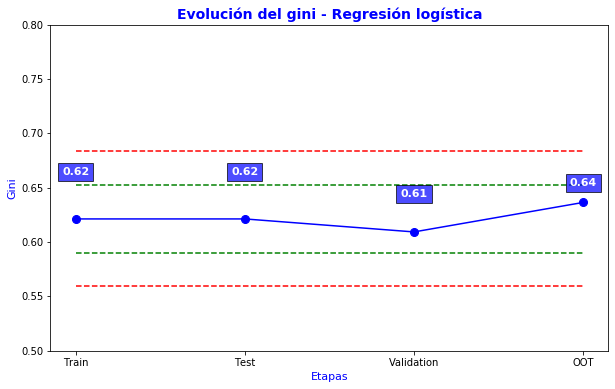

In [62]:
plt.figure(figsize=(10,6))
plt.plot(Tabla2['Etapa'],Tabla2['Gini'], color='blue',marker='o',markersize=8)
plt.plot(Tabla2['Etapa'],Tabla2['Banda_superior'], color='green',ls='--')
plt.plot(Tabla2['Etapa'],Tabla2['Banda_inferior'], color='red',linestyle='dashed')
plt.plot(Tabla2['Etapa'],Tabla2['Banda_superior_2'], color='red',ls='--')
plt.plot(Tabla2['Etapa'],Tabla2['Banda_inferior_2'], color='green',linestyle='dashed')
plt.ylim(0.5,0.8)
plt.ylabel('Gini',fontsize=11, color='blue')
plt.xlabel('Etapas', fontsize=11, color='blue')
plt.title('Evolución del gini - Regresión logística',fontweight='bold', fontsize=14, color='blue')

eje_x=Tabla2['Etapa']
eje_y=np.round(Tabla2['Gini'],2)
eje_y_alt=[0.66,0.66,0.64,0.65]

for x, y, z in zip(eje_x, eje_y,eje_y_alt):
    plt.text(x, z, y, ha='center', va='bottom', fontweight='bold',fontsize=11,bbox=dict(facecolor='blue', alpha=0.7), color='white')

plt.show()

**Fin**